# **Complex Orchard - Sample MAPPO**
This notebook is an adaption of the Sample MAPPO for the Simple Orchard to work with our more complex Orchard environment.



# Requirements

In [1]:
# %%capture
# # @title Install `mava` & `jumanji`

# # below installs all the required mava packages
# ! pip install git+https://github.com/instadeepai/mava.git@develop

# # module for reloading clone without having to delete runtime


In [1]:
# @title Import `mava` & `jumanji` packages

# for registering environments
from jumanji import register

# below are the needed mava packages within notebook
from mava.evaluator import get_eval_fn, make_ff_eval_act_fn

# other needed packages
import pandas as pd
import numpy as np
from omegaconf import OmegaConf
import shutil
import os
import sys
import importlib
import inspect
from IPython.display import Image, display

# %load_ext autoreload

In [ ]:
# # @title Cloning `applesauce` repo

# # Define the repository path and branch
# repo_path = '/content/applesauce'
# repo_url = 'https://github.com/riverliway/applesauce.git'
# repo_branch = 'erik'
# repo_python_path = os.path.join(repo_path, "python")

# # function for fresh clone of repo.
# def update_repo():
#     if os.path.exists(repo_path):
#         print("Repository exists. Deleting it...")
#         shutil.rmtree(repo_path)  # Remove the existing repository directory

#     print("Cloning the repository...")
#     !git clone --branch {repo_branch} {repo_url} {repo_path}

#     # Add the repo to Python path if not already added
#     if repo_python_path not in sys.path:
#         sys.path.append(repo_python_path)

# # Call the function to update the repository
# importlib.invalidate_caches()
# update_repo()

Cloning the repository...
Cloning into '/content/applesauce'...
remote: Enumerating objects: 2184, done.
remote: Counting objects: 100% (646/646), done.
remote: Compressing objects: 100% (315/315), done.
remote: Total 2184 (delta 410), reused 513 (delta 331), pack-reused 1538 (from 1)
Receiving objects: 100% (2184/2184), 3.04 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (1236/1236), done.


In [5]:
# @title Importing `applesauce` packages

# # the following aids in reloading packages when changes are made to the repo.
# %reload_ext autoreload
# %autoreload 2

#importing our custom jumanji (and mava) packages
from jumanji_env.environments.complex_orchard.env import ComplexOrchard
from jumanji_env.environments.complex_orchard.orchard_types import ComplexOrchardObservation, ComplexOrchardState, ComplexOrchardEntity
from jumanji_env.environments.complex_orchard.generator import ComplexOrchardGenerator
from jumanji_env.environments.complex_orchard import custom_mava
importlib.reload(custom_mava)
from jumanji_env.environments.complex_orchard.custom_mava import make_env
from apple_mava.ff_networks import Actor, Critic
from apple_mava.render_logging import *
from apple_mava.ff_mappo import *

In [4]:
# this is a workaround to get python to call the correct make_env. It was pulling the simple version first.
importlib.reload(custom_mava)
from jumanji_env.environments.complex_orchard.custom_mava import make_env
print(inspect.getfile(make_env))

/home/ubuntu/applesauce/python/jumanji_env/environments/complex_orchard/custom_mava.py


# Experiment Setup

The experiment setup includes: defining the hyperparameters, creating environments, setting up the learner and evaluator, and initialising some variables for plotting and logging purposes.


## Config

We start the experiment setup by defining the config dictionary that represents a set of the various hyperparameters for the experiment.

In addition to the typical hyperparameters used in MARL algorithms, we define below a few variables relevant to our implementation:

`num_updates`: The number of gradient updates to perform during the training.

`num_envs`:  Number of vectorised environments per device. For instance, if set to 512, it implies that 512 environments will be running in parallel at the same time on a given process.

`num_evaluation` and `num_eval_episodes`: The `num_evaluation` parameter specifies how many evenly spaced evaluation steps will occur during training, while the `num_eval_episode` specifies how many episodes will be rolled out at each evaluation step.

In [5]:
config = {
    "system": {
        "actor_lr": 2.5e-4,
        "critic_lr": 2.5e-4,
        "update_batch_size": 2,
        "rollout_length": 128,
        "num_updates": 400,
        "ppo_epochs": 16,
        "num_minibatches":32,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_eps": 0.2,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "add_agent_id": True,
        "decay_learning_rates": False,
        "seed": 42,
    },
    "arch": {
        "num_envs": 512,
        "num_eval_episodes": 32,
        "num_evaluation": 20,
        "evaluation_greedy": False,
        "num_absolute_metric_eval_episodes": 32,
    },
    "env": {
        "eval_metric": "episode_return",
        "implicit_agent_id": False,
        "log_win_rate": False,
        "kwargs": {"time_limit": 500},
        "scenario": {
            "task_config": {
                "width": 500,
                "height": 500,
                "num_picker_bots": 2,
                "num_pusher_bots": 0,
                "num_baskets": 1,
            },
            "env_kwargs": {},
        },
    },
}
# Convert the Python dictionary to a DictConfig
config: DictConfig = OmegaConf.create(config)

# Convert config to baseline for easy print out review
config = apply_baseline_config(config, use_baseline=True)

## Create Environments

We use Mava's utility functions to create our environments for us. These environments will have a seuqnece of wrappers applied to them that will add agent identifiers and will log any relevant metrics. Since MAPPO has a centralised critic, we will also need the environment to return the true underlying environment state along with the individual agent observations. This is why we pass in `add_global_state=True`. FOr more information on all the wrappers that are applied, please see [here](https://github.com/instadeepai/Mava/blob/8b758133056e86303ab1acbe5aa2ade02e0f6e70/mava/utils/make_env.py#L86).

In [6]:
# File to store the current version
version_file = "orchard_version.txt"

# Function to get the next version number
def get_next_version():
    if os.path.exists(version_file):
        with open(version_file, "r") as file:
            current_version = int(file.read().strip())
    else:
        current_version = 0  # Default to version 0 if the file doesn't exist

    next_version = current_version + 1

    # Save the next version to the file
    with open(version_file, "w") as file:
        file.write(str(next_version))

    return next_version

# Get the next version number
version_number = get_next_version()

# Assign orchard name with the updated version
orchard_version_name = f'ComplexOrchard-v{version_number}'

# Register the orchard
register(
    id=orchard_version_name,
    entry_point='__main__:ComplexOrchard',
)

print(f"Registered orchard version: {orchard_version_name}")

Registered orchard version: ComplexOrchard-v1


In [7]:
# make the training and evaluation orchards
env, eval_env = make_env(orchard_version_name, config, add_global_state=True)


## Learner and Evaluator Setup



In [8]:
# PRNG keys.
key = jax.random.PRNGKey(config.system.seed)
key, key_e, actor_net_key, critic_net_key = jax.random.split(key, num=4)

# Setup learner.
learn, actor_network, learner_state = learner_setup(
    env, (key, actor_net_key, critic_net_key), config
)

eval_act_fn = make_ff_eval_act_fn(actor_network.apply, config)

# Setup evaluator.
evaluator = get_eval_fn(eval_env, eval_act_fn, config, absolute_metric=False)
absolute_metric_evaluator = get_eval_fn(eval_env, eval_act_fn, config, absolute_metric=True)

# Add total timesteps to the config and compute environment steps per rollout.
steps_per_rollout, config = compute_total_timesteps(config)

E1130 04:53:00.993417    3162 buffer_comparator.cc:157] Difference at 0: 1.58779, expected 1.58779
E1130 04:53:00.993455    3162 buffer_comparator.cc:157] Difference at 1: 0.403745, expected 0.403745
E1130 04:53:00.993461    3162 buffer_comparator.cc:157] Difference at 2: 0.70014, expected 0.70014
E1130 04:53:00.993465    3162 buffer_comparator.cc:157] Difference at 3: 1.17207, expected 1.17207
E1130 04:53:00.993469    3162 buffer_comparator.cc:157] Difference at 4: 0.353305, expected 0.353305
E1130 04:53:00.993473    3162 buffer_comparator.cc:157] Difference at 5: 0.641906, expected 0.641906
E1130 04:53:00.993476    3162 buffer_comparator.cc:157] Difference at 6: 0.472625, expected 0.472625
E1130 04:53:00.993479    3162 buffer_comparator.cc:157] Difference at 7: 0.543444, expected 0.543444
E1130 04:53:00.993483    3162 buffer_comparator.cc:157] Difference at 8: 0.603256, expected 0.603256
E1130 04:53:00.993486    3162 buffer_comparator.cc:157] Difference at 9: 1.58051, expected 1.5805

# Run Experiment

Now that the code has been compiled using JAX, its execution will benefit from optimised performance. We will proceed to train the MAPPO algorithm on the `small-4ag-easy` scenario from RobotWarehouse. The experiment follows a cyclic pattern, transitioning from training to evaluation and back to training.

The training phase consists of performing 400 updates. Each update utilizes 512 parallel environments, with a rollout of 128 steps per environment and a batch of two vectorised full gradient update steps are performend. This comprehensive process results in over 50 million timesteps utilised for training.

In [9]:
# Run experiment for a total number of evaluations.
ep_returns = []
start_time = time.time()
n_devices = len(jax.devices())

# exploring code for a single evaluation
# un-comment for multiple evaluations.
for _ in range(config["arch"]["num_evaluation"]):
    # Train.
    learner_output = learn(learner_state)
    jax.block_until_ready(learner_output)

    # collecting training data

    # Prepare for evaluation.
    trained_params = unreplicate_batch_dim(learner_state.params.actor_params)

    key_e, *eval_keys = jax.random.split(key_e, n_devices + 1)
    eval_keys = jnp.stack(eval_keys)
    eval_keys = eval_keys.reshape(n_devices, -1)

    # Evaluate.
    evaluator_output = evaluator(trained_params, eval_keys, {})
    jax.block_until_ready(evaluator_output)

    mean_episode_return = jnp.mean(evaluator_output["episode_return"])
    ep_returns = plot_performance(mean_episode_return, ep_returns, start_time, config)

    # Update runner state to continue training.
    learner_state = learner_output.learner_state

# Return trained params to be used for rendering or testing.
trained_params = unreplicate_n_dims(trained_params, unreplicate_depth=1)

print(f"{Fore.CYAN}{Style.BRIGHT}MAPPO experiment completed{Style.RESET_ALL}")

MAPPO experiment completed


# Review Outputs

In [ ]:
# # extracting learner state, episode and train metrics
# learner_state, episode_metrics, train_metrics = learner_output
# # reviewing episode metrics
# episode_metrics

In [ ]:
# # reviewing train metrics
# train_metrics

In [10]:
data = learner_state.timestep.extras

def table_episode_metrics(data):
  # Flattening the nested arrays
  episode_length = data['episode_metrics']['episode_length'].flatten()
  episode_return = data['episode_metrics']['episode_return'].flatten()
  is_terminal_step = data['episode_metrics']['is_terminal_step'].flatten()
  percent_collected = data['percent_collected'].flatten()

  # Creating a dictionary for Pandas
  flattened_data = {
      'episode_length': episode_length,
      'episode_return': episode_return,
      'is_terminal_step': is_terminal_step,
      'percent_collected': percent_collected
  }

  # Creating the DataFrame
  df = pd.DataFrame(flattened_data)

  # Display the DataFrame
  return df

table = table_episode_metrics(data)
table.describe()

episode_length  episode_return  percent_collected
count             1.0             1.0                1.0
mean              0.0             0.0                0.0
std               NaN             NaN                NaN
min               0.0             0.0                0.0
25%               0.0             0.0                0.0
50%               0.0             0.0                0.0
75%               0.0             0.0                0.0
max               0.0             0.0                0.0

In [11]:
data

{'episode_metrics': {'episode_length': Array([[[0]]], dtype=int32),
  'episode_return': Array([[[0.]]], dtype=float32),
  'is_terminal_step': Array([[[False]]], dtype=bool)},
 'number_picked': Array([[[0]]], dtype=int32),
 'percent_collected': Array([[[0.]]], dtype=float32),
 'real_next_obs': ComplexOrchardObservation(agents_view=Array([[[[[ 11.623917 , -11.409882 ,  -0.7761061],
           [ 15.498627 ,  24.310303 ,   1.0032351]]]]], dtype=float32), action_mask=Array([[[[[ True,  True,  True,  True,  True,  True,  True],
           [ True,  True,  True,  True,  True,  True,  True]]]]],      dtype=bool), step_count=Array([[[0]]], dtype=int32))}

# Rendering

Now let's render one episode using the trained system

> Note: Creating a complete episode animation can be time-consuming. To address this, we offer a parameter named `max_steps` for the `render_one_episode` function. This parameter determines the number of states displayed in the GIF. Please note that a full episode usually consists of 500 steps.

In [12]:
render_data = render_one_episode_complex(orchard_version_name, config, trained_params, max_steps=450, verbose=True)

Number of Apples: 35
Apple locations: [[297.60791015625, 354.79888916015625], [283.765869140625, 363.5740051269531], [325.0975036621094, 426.261474609375], [260.5357360839844, 375.9680480957031], [249.41342163085938, 379.2906188964844], [257.5351867675781, 455.0130615234375], [229.63804626464844, 388.7279052734375], [210.2021942138672, 462.0445556640625], [188.14976501464844, 453.9312744140625], [152.97296142578125, 467.6962890625], [148.40914916992188, 432.5064697265625], [106.60202026367188, 437.0799865722656], [144.04421997070312, 384.9312744140625], [129.82275390625, 372.959716796875], [99.42153930664062, 360.6974182128906], [65.420654296875, 337.28729248046875], [115.78191375732422, 320.9023132324219], [81.91122436523438, 287.8060302734375], [113.51656341552734, 278.7184143066406], [161.9902801513672, 291.98895263671875], [158.5655975341797, 270.72894287109375], [157.12330627441406, 238.855712890625], [189.5866241455078, 271.2467041015625], [200.31741333007812, 267.6590270996094],

In [ ]:
generate_gif(render_data, "rendered_simulation.gif")
# Display the .gif in the notebook

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

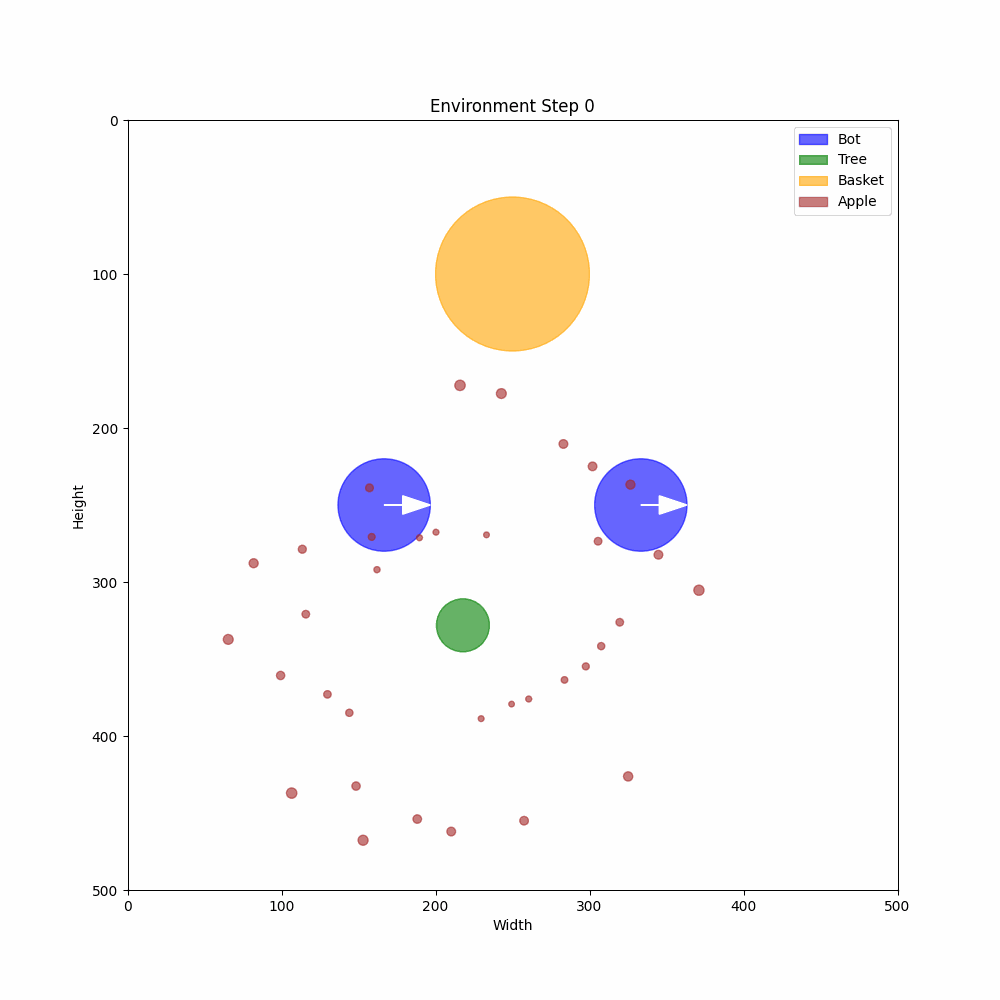

In [ ]:
display(Image(filename="rendered_simulation.gif"))

In [ ]:
render_data

[{'width': Array(500, dtype=int32),
  'height': Array(500, dtype=int32),
  'seed': 42,
  'time': Array(0, dtype=int32),
  'bots': [{'x': 166.6666717529297,
    'y': 250.0,
    'diameter': 60,
    'holding': -1,
    'job': 'picker',
    'orientation': 0.0},
   {'x': 333.3333435058594,
    'y': 250.0,
    'diameter': 60,
    'holding': -1,
    'job': 'picker',
    'orientation': 0.0}],
  'trees': [{'x': 217.80319213867188,
    'y': 328.1326904296875,
    'diameter': 34.439239501953125}],
  'baskets': [{'x': 250.0, 'y': 100.0, 'diameter': 100}],
  'apples': [{'x': 297.60791015625,
    'y': 354.79888916015625,
    'diameter': 4.532721996307373,
    'held': False,
    'collected': False},
   {'x': 283.765869140625,
    'y': 363.5740051269531,
    'diameter': 4.292238712310791,
    'held': False,
    'collected': False},
   {'x': 325.0975036621094,
    'y': 426.261474609375,
    'diameter': 5.980840682983398,
    'held': False,
    'collected': False},
   {'x': 260.5357360839844,
    'y': 37

In [ ]:
# Disconnect session after completing run.
# from google.colab import runtime
# runtime.unassign()